In [1]:
from datascience import *
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
def standard_units(arr):
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

def slope(t, x, y):
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

def fitted_values(t, x, y):
    """Return an array of the regression estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

def residuals(t, x, y):
    predictions = fitted_values(t, x, y)
    return t.column(y) - predictions

## Confidence interval for the slope

In [3]:
births = Table.read_table('baby.csv')
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


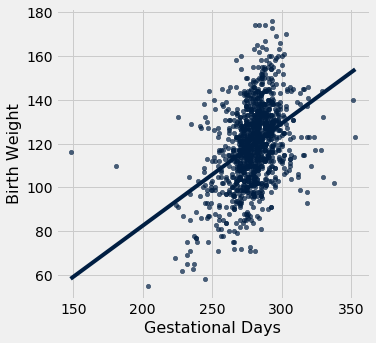

In [4]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

In [5]:
def bootstrap_slope(t, x, y, repetitions=5000):
    
    # Bootstrap the scatter, find the slope, collect
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(t, x, y)
    
    # Display results
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the slope of the true line:')
    print(left, 'to', right)

In [6]:
slope(births, 'Gestational Days', 'Birth Weight')

0.4665568769492152

Slope of regression line: 0.4665568769492152
Approximate 95%-confidence interval for the slope of the true line:
0.37829612131098117 to 0.5547320377316023


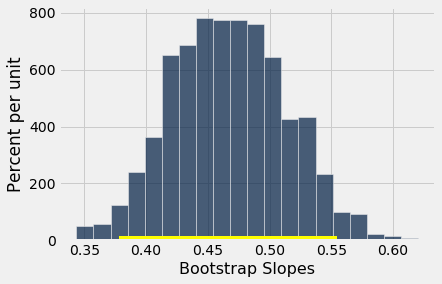

In [7]:
bootstrap_slope(births, 'Gestational Days', 'Birth Weight', 1000)

In [8]:
def draw_line(slope, intercept, x, color='r'):
    y = x*slope + intercept
    plots.plot(x, y, color=color, linewidth=.75)
    
def bootstrap_slope_and_intercept(t, x, y, repetitions=100):
    
    # Bootstrap the scatter, find the slope, collect
    slopes = make_array()
    intercepts = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        bootstrap_intercept = intercept(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
        intercepts = np.append(intercepts, bootstrap_intercept)

    plots.scatter(t.column(x), t.column(y))
    xs = make_array(np.min(t.column(x)), np.max(t.column(x)))
    for i in np.arange(10):
        draw_line(slope=slopes[i], intercept=intercepts[i], x=xs)



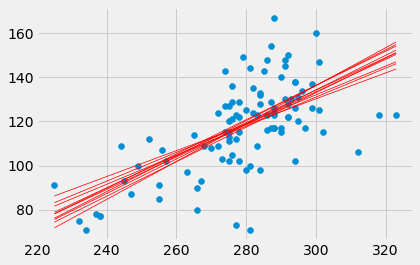

In [9]:
bootstrap_slope_and_intercept(births.sample(100), 'Gestational Days', 'Birth Weight')


## Classification

In [10]:
# ckd = chronic kidney disease
# class = 1 = has ckd
# class = 0 = does not have ckd

ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd.show(10)

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1
68,80,1.01,3,2,normal,abnormal,present,present,157,90,4.1,130,6.4,5.6,16,11000,2.6,yes,yes,yes,poor,yes,no,1
61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,148,3.9,135,5.2,7.7,24,9200,3.2,yes,yes,yes,poor,yes,yes,1
48,80,1.025,4,0,normal,abnormal,notpresent,notpresent,95,163,7.7,136,3.8,9.8,32,6900,3.4,yes,no,no,good,no,yes,1
69,70,1.01,3,4,normal,abnormal,notpresent,notpresent,264,87,2.7,130,4,12.5,37,9600,4.1,yes,yes,yes,good,yes,no,1
73,70,1.005,0,0,normal,normal,notpresent,notpresent,70,32,0.9,125,4,10,29,18900,3.5,yes,yes,no,good,yes,no,1
73,80,1.02,2,0,abnormal,abnormal,notpresent,notpresent,253,142,4.6,138,5.8,10.5,33,7200,4.3,yes,yes,yes,good,no,no,1
46,60,1.01,1,0,normal,normal,notpresent,notpresent,163,92,3.3,141,4,9.8,28,14600,3.2,yes,yes,no,good,no,no,1


In [11]:
ckd.group('Class')

Class,count
0,115
1,43


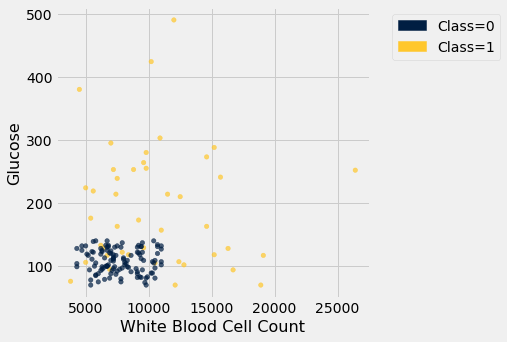

In [12]:
#Could you predict if a patient has ckd?
ckd.scatter('White Blood Cell Count', 'Glucose', colors='Class')

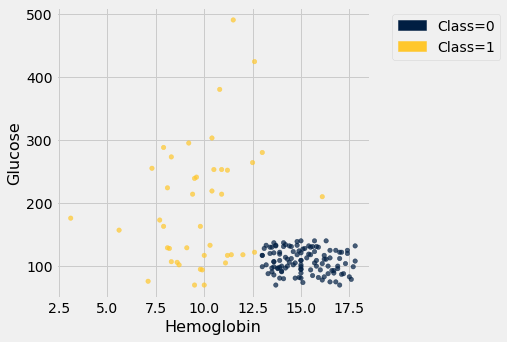

In [13]:
ckd.scatter('Hemoglobin', 'Glucose', colors='Class')

In [14]:
#Can you tell if a bank note is counterfeit or legitimate?
#Variables based on photgraphs of many banknotes (a few numbers for each image calculated)

banknotes = Table.read_table('banknote.csv')
banknotes

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
3.6216,8.6661,-2.8073,-0.44699,0
4.5459,8.1674,-2.4586,-1.4621,0
3.866,-2.6383,1.9242,0.10645,0
3.4566,9.5228,-4.0112,-3.5944,0
0.32924,-4.4552,4.5718,-0.9888,0
4.3684,9.6718,-3.9606,-3.1625,0
3.5912,3.0129,0.72888,0.56421,0
2.0922,-6.81,8.4636,-0.60216,0
3.2032,5.7588,-0.75345,-0.61251,0
1.5356,9.1772,-2.2718,-0.73535,0


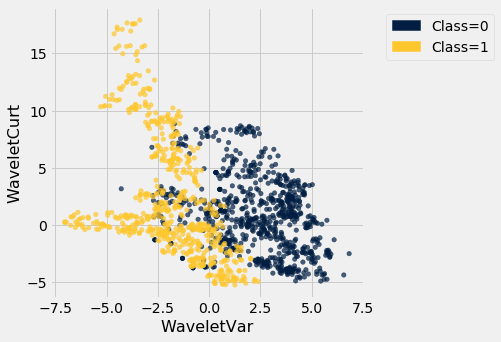

In [15]:
banknotes.scatter('WaveletVar', 'WaveletCurt', colors='Class')

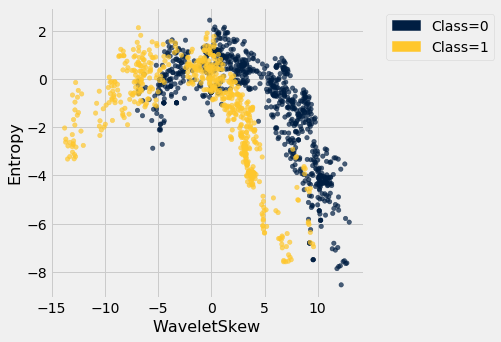

In [16]:
banknotes.scatter('WaveletSkew', 'Entropy', colors='Class')

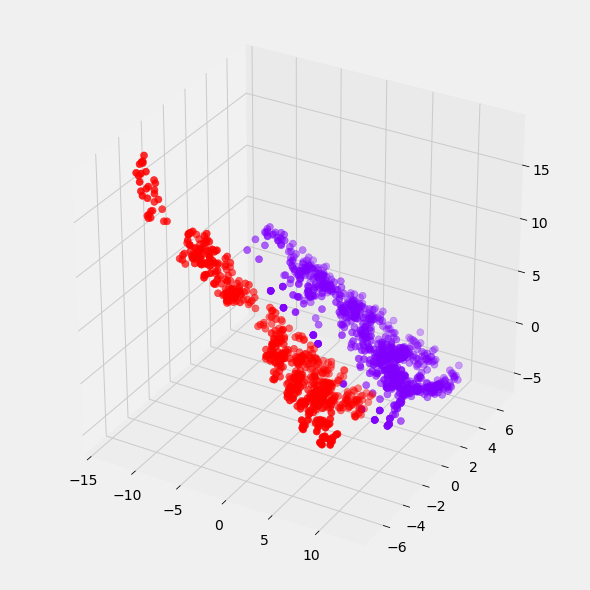

In [17]:
#Two attributes have some overlap of classes...what happens with three attributes?
fig = plots.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(banknotes.column('WaveletSkew'), 
           banknotes.column('WaveletVar'), 
           banknotes.column('WaveletCurt'), 
           c=banknotes.column('Class'),
           cmap='rainbow', #'viridis',
          s=50);